In [1]:
import os
import sys
from datetime import datetime
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
parent_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(parent_folder)
sys.path.append(parent_folder)

C:\Users\rasmusso\Desktop\preprocessing-mitgcm


In [3]:
from configs.config_object import ConfigObject
from grid_and_bathy import get_dz_grid, get_grid
from surface_forcings import extract_and_save_surface_forcings, download_weather_reanalysis, download_weather_forecast
from initial_conditions import download_profile_idronaut_datalakes, create_initial_temperature_from_measure_profile, parse_alplakes_1d_from_directory
from run_preprocessing import write_data_config_files, copy_template, remove_all_files_and_folders, write_size_config_files
from utils import modify_arguments, convert_binary_files

## Load config

In [4]:
config = ConfigObject('configs/config.json')
output_folder = './99-output/'
template_folder = os.path.join('./00-template_mitgcm/', config.template_folder)
print(template_folder)

./00-template_mitgcm/zurich_base


In [5]:
parsed_start_date = datetime.strptime(config.start_date, '%Y%m%d')
parsed_end_date = datetime.strptime(config.end_date, '%Y%m%d')
parsed_ref_date = datetime.strptime(config.reference_date, '%Y%m%d')

sim_duration_in_second = (parsed_end_date - parsed_start_date).total_seconds()
start_time_in_second_from_ref_date = (parsed_start_date - parsed_ref_date).total_seconds()
end_time_in_second_from_ref_date = (parsed_end_date - parsed_ref_date).total_seconds()

## Initialize output folder

In [6]:
remove_all_files_and_folders(output_folder)
#copy_template('./00-template_mitgcm/geneva_base', output_folder)
copy_template(template_folder, output_folder)
config.write_metadata_to_file(os.path.join(output_folder, 'metadata_simulation.txt'))

## Get MITgcm grid

#In case the grid has not been created yet
build_and_save_mitgcm_grid(config.paths.grid_folder_path, 
                           config.Nx, 
                           config.Ny, 
                           config.grid_resolution, 
                           config.x0_ch1903, 
                           config.y0_ch1903, 
                           config.x1_ch1903, 
                           config.y1_ch1903)

In [7]:
mitgcm_grid = get_grid(config.paths.grid_folder_path)

## Build binary files

In [8]:
binary_data_folder = os.path.join(output_folder, 'binary_data')
if not os.path.exists(binary_data_folder):
    os.makedirs(binary_data_folder)
    print(f"Directory '{binary_data_folder}' created.")

Directory './99-output/binary_data' created.


**Get bathymetry**

In [9]:
#To create bathymetry, see notebook 'create_bathy'
shutil.copy(config.paths.bathy_path, os.path.join(binary_data_folder, 'bathy.bin'))

'./99-output/binary_data\\bathy.bin'

**Get surface forcings**
run to dowload external forcing.
Once downloaded, no need to run that cell again

In [10]:
buffer = config.weather_download_buffer
if config.weather_model_type == 'reanalysis':
    download_weather_reanalysis(config.weather_api_base_url, 
                                config.start_date, config.end_date, 
                                mitgcm_grid.lat_grid.min() - buffer, 
                                mitgcm_grid.lon_grid.min() - buffer, 
                                mitgcm_grid.lat_grid.max() + buffer, 
                                mitgcm_grid.lon_grid.max() + buffer, 
                                config.paths.raw_results_from_api_folder)
    print('Finished downloading weather reanalysis')
elif config.weather_model_type == 'forecast':
    download_weather_forecast(config.weather_api_base_url, 
                                config.start_date,  
                                mitgcm_grid.lat_grid.min() - buffer, 
                                mitgcm_grid.lon_grid.min() - buffer, 
                                mitgcm_grid.lat_grid.max() + buffer, 
                                mitgcm_grid.lon_grid.max() + buffer, 
                                config.paths.raw_results_from_api_folder)
    print('Finished downloading weather forecasts')

Data already exists: C:\Users\rasmusso\Documents\ZH\data\meteo\continuous reanalysis\20240301_20240301_GLOB.jsonData already exists: C:\Users\rasmusso\Documents\ZH\data\meteo\continuous reanalysis\20240301_20240301_U.json
Data already exists: C:\Users\rasmusso\Documents\ZH\data\meteo\continuous reanalysis\20240301_20240301_T_2M.json
Data already exists: C:\Users\rasmusso\Documents\ZH\data\meteo\continuous reanalysis\20240301_20240301_V.json
Data already exists: C:\Users\rasmusso\Documents\ZH\data\meteo\continuous reanalysis\20240301_20240301_RELHUM_2M.json

Data already exists: C:\Users\rasmusso\Documents\ZH\data\meteo\continuous reanalysis\20240301_20240301_PS.json
Data already exists: C:\Users\rasmusso\Documents\ZH\data\meteo\continuous reanalysis\20240301_20240301_CLCT.json
Data already exists: C:\Users\rasmusso\Documents\ZH\data\meteo\continuous reanalysis\20240302_20240302_T_2M.json
Data already exists: C:\Users\rasmusso\Documents\ZH\data\meteo\continuous reanalysis\20240301_20240

In [11]:
time_format = 'UTC'
extract_and_save_surface_forcings(binary_data_folder, 
                                  config.start_date, 
                                  config.end_date, 
                                  config.paths.raw_results_from_api_folder, 
                                  mitgcm_grid,
                                  1, # Number of cores used in interpolation
                                  config.weather_model_type)

Interpolating U to grid...
Saving u10...
Interpolating V to grid...
Saving v10...
Interpolating GLOB to grid...
Saving swdown...
Interpolating T_2M to grid...
Saving atemp...
Interpolating PS to grid...
Saving apressure...
Computing specific humidity (aqh)...
Interpolating RELHUM_2M to grid...
Saving relhum...
Saving aqh...
Computing longwave radiation (lwdown)...
Interpolating CLCT to grid...
Saving clct...
Saving lwdown...
Done computing binary data.


**Convert to little endian if necessary** (for cscs computation)

In [12]:
# TO DO : implement check to see whether the datatypes are correct
if config.endian_type == 'little_endian':
    convert_binary_files(os.path.join(output_folder, 'binary_data'), '>f8', '<f8')

## Get initial conditions
### 1. From excel file

In [13]:
df = pd.read_excel(r'C:\Users\rasmusso\Documents\ZH\data\measurement kanton\zurich_profile_2024.xlsx')
available_dates_meas = df.columns[1:].tolist()
print(available_dates_meas)

['03.01.2024', '07.02.2024', '06.03.2024', '03.04.2024', '07.05.2024', '05.06.2024', '03.07.2024', '07.08.2024', '04.09.2024', '09.10.2024', '06.11.2024', '04.12.2024']


In [14]:
# Choisir sa date de mesure (available_dates_meas) en entrant le mois (int)
month = 3    # btwn 3 and 12 for 2024
temperature_month = df[available_dates_meas[month-1]]
depth = df['Depth']
date_profil = pd.to_datetime(available_dates_meas[month-1], format="%d.%m.%Y")

ds = xr.Dataset(
    data_vars={
        "temp": ("depth", temperature_month)
    },
    coords={
        "depth": depth,
        "time": date_profil  # Coordonnée scalaire
    }
)
ds

<xarray.Dataset>
Dimensions:  (depth: 12)
Coordinates:
  * depth    (depth) int64 0 5 10 15 20 40 60 80 100 120 130 135
    time     datetime64[ns] 2024-03-06
Data variables:
    temp     (depth) float64 6.8 6.8 6.8 6.6 6.1 5.9 5.7 5.6 5.4 5.4 5.3 5.3

In [15]:
#preparing the input for the IC plot
dz_grid = get_dz_grid(config.paths.dz_grid_csv_path)
shaped_temp_initial = create_initial_temperature_from_measure_profile(dz_grid, ds)
shaped_t_plot = shaped_temp_initial.flatten()
shaped_t_plot = shaped_t_plot[:-6]
len(shaped_t_plot)

74

file_date, measured_temperature = download_profile_idronaut_datalakes(parsed_start_date)
print('Initial conditions from Idronaut file from ', file_date)
config.paths.dz_grid_csv_path)
shaped_temp_initial = create_initial_temperature_from_measure_profile(dz_grid, measured_temperature)

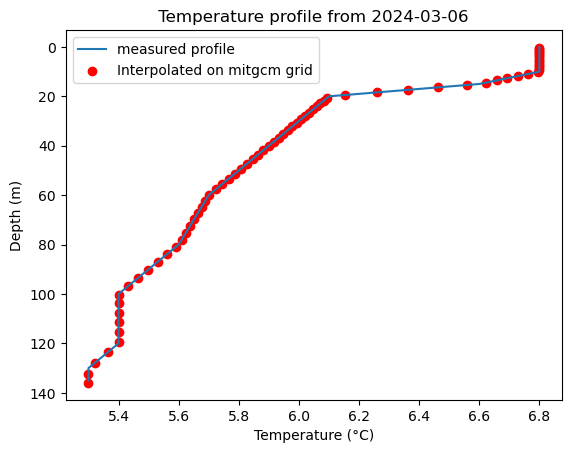

In [16]:
#PLOT THE INTERPOLATION OF INITIAL CONDITIONS
date_profil = pd.to_datetime(ds.time.values).date()
plt.plot(ds["temp"].values,depth.values,label="measured profile")  # y='depth' makes depth vertical (standard for ocean/atmo data)
plt.scatter(shaped_t_plot,dz_grid[~np.isnan(dz_grid)].cumsum().flatten(),color='red',label="Interpolated on mitgcm grid")
plt.gca().invert_yaxis()  # Depth increases downward
plt.title(f" Temperature profile from {date_profil} ")
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()

## From Simstrat results (Aplakes)
#simstrat_temperature = parse_alplakes_1d_from_directory(r'./initial_conditions/simstrat_data')
profile_simstrat = simstrat_temperature.sel(time = parsed_start_date, method='nearest')
print('Initial conditions from Simstrat ', profile_simstrat.time.values)
dz_grid = get_dz_grid(config.paths.dz_grid_csv_path)
shaped_temp_initial = create_initial_temperature_from_measure_profile(dz_grid, profile_simstrat)

### Get pickup files

In [17]:
if config.with_pickup:
    dt_sim_in_second = config.time_step
    pickup_number = f"pickup.{str(int(start_time_in_second_from_ref_date / dt_sim_in_second)).zfill(10)}"
else:
    pickup_number = ""
print(pickup_number)

### Adapt config files

In [18]:
modify_arguments('!reference_date!', [config.reference_date], os.path.join(output_folder, 'run_config/data.cal'))

In [19]:
write_data_config_files(os.path.join(output_folder, 'run_config/data'), 
                        shaped_temp_initial, 
                        start_time_in_second_from_ref_date, 
                        end_time_in_second_from_ref_date,
                        pickup_number,
                        dz_grid, 
                        config.grid_resolution,
                        config.time_step)

In [20]:
modify_arguments('!start_date!', [config.start_date], os.path.join(output_folder, 'run_config/data.exf'))

In [21]:
use_exch2=False
# Package to ignore cores that are attributed to land. See notebook grid_and_bathy/check_core_allocation to create files land_cores_Px..etc.txt.
# Doc here: https://wiki.math.uwaterloo.ca/fluidswiki/index.php?title=MITgcm_tips#Setting_the_equation_of_state (look for exch2)
# And there: https://mitgcm.readthedocs.io/en/latest/phys_pkgs/exch2.html (not so helpful... don't we love the official documentation of MITgcm?)
if use_exch2:    
    blank_list_path=os.path.join(config.paths.grid_folder_path, f"land_cores_Px{config.Px}_Py{config.Py}.txt")
    with open(blank_list_path, "r") as file:
        nb_blank_cores, blank_list = file.read().splitlines()
        
    Px = (config.Px * config.Py) - int(nb_blank_cores)
    Py = 1
    
    modify_arguments('!Nx!', [config.Nx], os.path.join(output_folder, 'run_config/data.exch2'))
    modify_arguments('!Ny!', [config.Ny], os.path.join(output_folder, 'run_config/data.exch2'))
    modify_arguments('!blank_list!', [blank_list], os.path.join(output_folder, 'run_config/data.exch2'))
else:
    Px = config.Px
    Py = config.Py

In [22]:
write_size_config_files(os.path.join(output_folder, 'code/SIZE.h'), 
                        Px, 
                        Py,
                        config.Nx, 
                        config.Ny, 
                        np.count_nonzero(~np.isnan(dz_grid)))

## Next steps

- Copy-paste the folders in "99-output" to the cscs server 
- Change #SBATCH --time=00:05:00 in run/submit-daint-short.sh
- Open CSCS putty console:

export MITGCM_ROOTDIR=/scratch/snx3000/aleroqua/MITgcm-checkpoint67z/

cd /scratch/snx3000/aleroqua/xx/build
$MITGCM_ROOTDIR/tools/genmake2 -mods ../code -mpi -enable=mnc -of ${MITGCM_ROOTDIR}/tools/build_options/linux_ia64_cray_archer
make depend
make -j 8

cd ..
rm -r run
mkdir run
cd run
ln -s ../pickup/* .
ln -s ../run_config/* .
cp ../build/mitgcmuv .

sbatch submit-daint-short.sh

### TO DO

In [ ]:
# add selection of pickup file
# add selection of pickup frequency, diagnostic frequency
# add selection of output type (mnc = true or false)
# add automatic change of computing time? (submit-daint)